In [56]:
%matplotlib inline

import pandas as pd
import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap

import seaborn as sns

from IPython.display import HTML
cmap = ListedColormap(sns.xkcd_palette(['denim blue', 'medium green', 'pale red']))
sns.set_style('white')

# plt.rcParams['animation.ffmpeg_args'] = '-report'
# plt.rcParams['animation.bitrate'] = 2000

In [57]:
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [58]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [59]:
features = iris.feature_names
data = pd.DataFrame(data=np.column_stack([iris.data, iris.target]), columns=features + ['label'])
data.label = data.label.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   label              150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


In [60]:
# Standardize Data
scaler = StandardScaler()
features_standardized = scaler.fit_transform(data[features])
n = len(data)

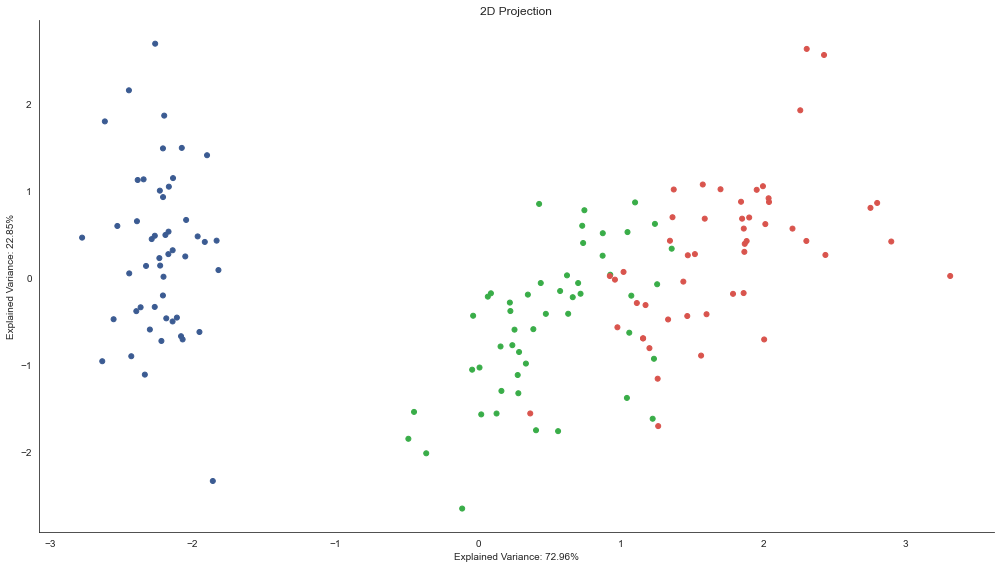

In [61]:
# Reduce Dimensionality to visualize clusters
pca = PCA(n_components=2)
features_2D = pca.fit_transform(features_standardized)
ev1, ev2 = pca.explained_variance_ratio_
ax = plt.figure(figsize=(14, 8)).gca()
ax.set_title('2D Projection')
ax.set_xlabel(f'Explained Variance: {ev1:.2%}')
ax.set_ylabel(f'Explained Variance: {ev2:.2%}')
ax.scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)
sns.despine()
plt.tight_layout()

In [62]:
Z = linkage(features_standardized, 'ward')
Z[:5]

array([[1.01000000e+02, 1.42000000e+02, 0.00000000e+00, 2.00000000e+00],
       [7.00000000e+00, 3.90000000e+01, 1.21167870e-01, 2.00000000e+00],
       [1.00000000e+01, 4.80000000e+01, 1.21167870e-01, 2.00000000e+00],
       [0.00000000e+00, 1.70000000e+01, 1.31632184e-01, 2.00000000e+00],
       [9.00000000e+00, 3.40000000e+01, 1.31632184e-01, 2.00000000e+00]])

In [63]:
linkage_matrix = pd.DataFrame(data=Z, columns=['cluster_1', 'cluster_2', 'distance', 'n_objects'],
                              index=range(1, n))
for col in ['cluster_1', 'cluster_2', 'n_objects']:
    linkage_matrix[col] = linkage_matrix[col].astype(int)
linkage_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 1 to 149
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cluster_1  149 non-null    int32  
 1   cluster_2  149 non-null    int32  
 2   distance   149 non-null    float64
 3   n_objects  149 non-null    int32  
dtypes: float64(1), int32(3)
memory usage: 3.0 KB


In [64]:
linkage_matrix.tail()

,cluster_1,cluster_2,distance,n_objects
145,283,289,4.243485,30
146,280,292,6.607812,49
147,290,293,8.004747,71
148,294,296,12.636844,101
149,295,297,27.249911,150


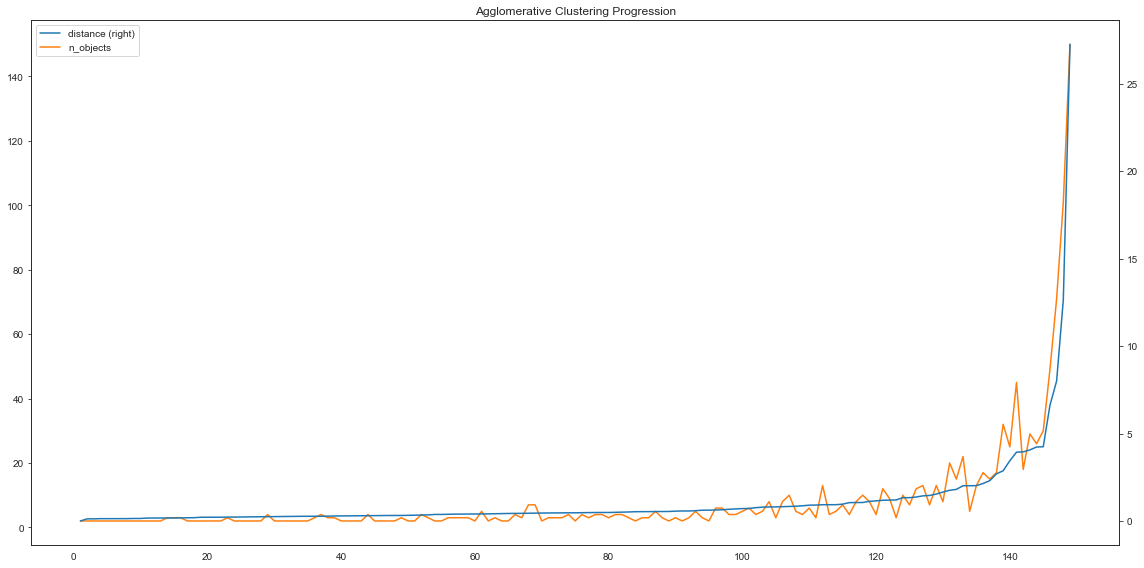

In [65]:
linkage_matrix[['distance', 'n_objects']].plot(secondary_y=['distance'],
                                               title='Agglomerative Clustering Progression', figsize=(16, 8))
plt.tight_layout();

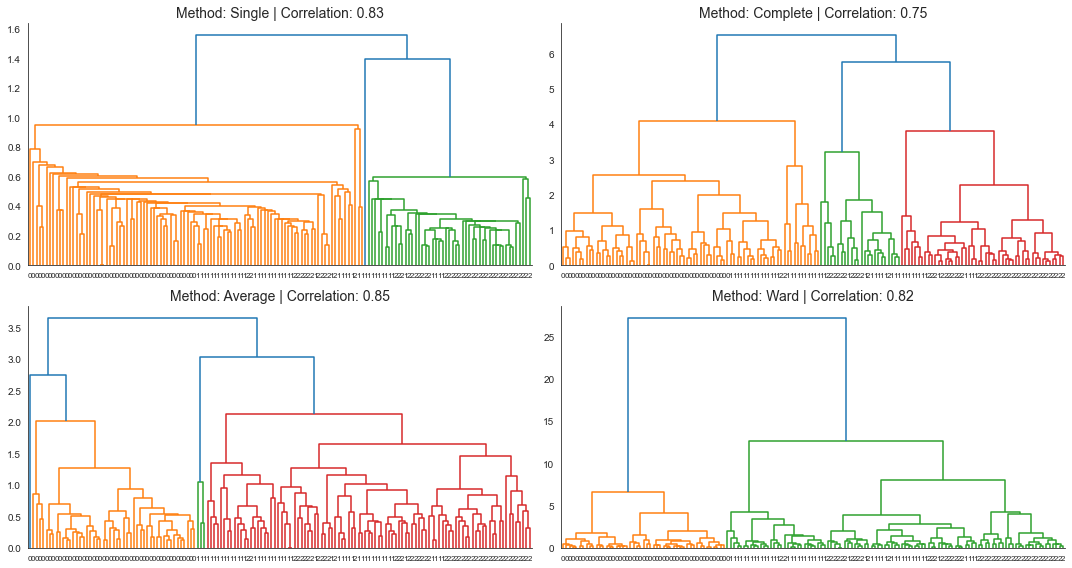

In [66]:
# Compare linkage types - measure of dissimilarity btw clusters has a significant impact on clustering result
# type 1) Single-link: Distance between the nearest neighbors of two clusters
# type 2) Complete link: Maximum distance between the respective cluster members
# type 3) Ward's method: Minimize within-cluster variance
# type 4) Group average: Uses the cluster midpoint as a reference distance
methods = ['single', 'complete', 'average', 'ward']
pairwise_distance = pdist(features_standardized)
fig, axes = plt.subplots(figsize=(15, 8), nrows=2, ncols=2, sharex=True)
axes = axes.flatten()
for i, method in enumerate(methods):
    Z = linkage(features_standardized, method)
    c, coph_dists = cophenet(Z, pairwise_distance)
    dendrogram(Z, labels=data.label.values, orientation='top', leaf_rotation=0., leaf_font_size=8., ax=axes[i])
    axes[i].set_title(f'Method: {method.capitalize()} | Correlation: {c:.2f}', fontsize=14)

sns.despine()
fig.tight_layout()

In [67]:
# Get Cluster Members
n = len(Z)
from collections import OrderedDict
clusters = OrderedDict()

for i, row in enumerate(Z, 1):
    cluster = []
    for c in row[:2]:
        if c <= n:
            cluster.append(int(c))
        else:
            cluster += clusters[int(c)]
    clusters[n+i] = cluster
clusters[230]

[144, 124, 120, 143]

In [68]:
# Animate Agglomerative Clustering
def get_2D_coordinates():
    points = pd.DataFrame(features_2D).assign(n=1)
    return dict(enumerate(points.values.tolist()))
n_clusters = Z.shape[0]
points = get_2D_coordinates()
cluster_states = {0: get_2D_coordinates()}

for i, cluster in enumerate(Z[:, :2], 1):
    cluster_state = dict(cluster_states[i-1])
    merged_points = np.array([cluster_state.pop(c) for c in cluster])
    cluster_size = merged_points[:, 2]
    new_point = np.average(merged_points[:, :2], axis=0, weights=cluster_size).tolist()
    new_point.append(cluster_size.sum())
    cluster_state[n_clusters+i] = new_point
    cluster_states[i] = cluster_state
cluster_states[100]

{15: [-2.262214531601023, 2.6862844851105936, 1.0],
 41: [-1.8581224563735697, -2.33741515755335, 1.0],
 60: [-0.1101962800006269, -2.6540728185365667, 1.0],
 62: [0.5621083064431803, -1.764724380616946, 1.0],
 106: [0.36701768786072647, -1.5615028914765072, 1.0],
 108: [2.006686467676607, -0.711438653547159, 1.0],
 109: [2.2597773490125004, 1.9210103764598878, 1.0],
 114: [1.4676452010173253, -0.4422715873770829, 1.0],
 176: [0.287115220753732, -0.24204262329732346, 2.0],
 179: [-2.2058211672986983, -0.09844552008358047, 2.0],
 185: [0.96881049909178, 0.019079153840815533, 3.0],
 194: [0.7389335833626243, 0.6838170188840111, 2.0],
 197: [2.369196586273951, 0.33967500639352904, 2.0],
 198: [-2.465791249585798, -0.9936714816693266, 3.0],
 205: [1.9290326043911594, 0.5634757376107681, 3.0],
 206: [-1.9303546578375996, 0.4980362956076004, 3.0],
 208: [-2.33244100242783, 0.10599232941089094, 3.0],
 209: [2.365628354573732, 2.5914923595139374, 2.0],
 210: [-2.375377894784248, -0.42847639960

RuntimeError: Requested MovieWriter (ffmpeg) not available

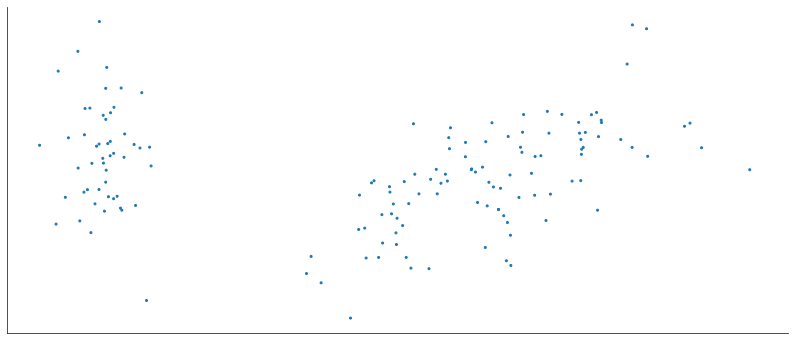

In [69]:
# Set up Animation
# %%capture
fig, ax = plt.subplots(figsize=(14, 6))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

sns.despine()
xmin, ymin = np.min(features_2D, axis=0) * 1.1
xmax, ymax = np.max(features_2D, axis=0) * 1.1
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
scat = ax.scatter([], [])

def animate(i):
    df = pd.DataFrame(cluster_states[i]).values.T
    scat.set_offsets(df[:, :2])
    scat.set_sizes((df[:, 2] * 2) ** 2)
    return scat,

anim = FuncAnimation(fig, animate, frames=cluster_states.keys(), interval=250, blit=False)

HTML(anim.to_html5_video())

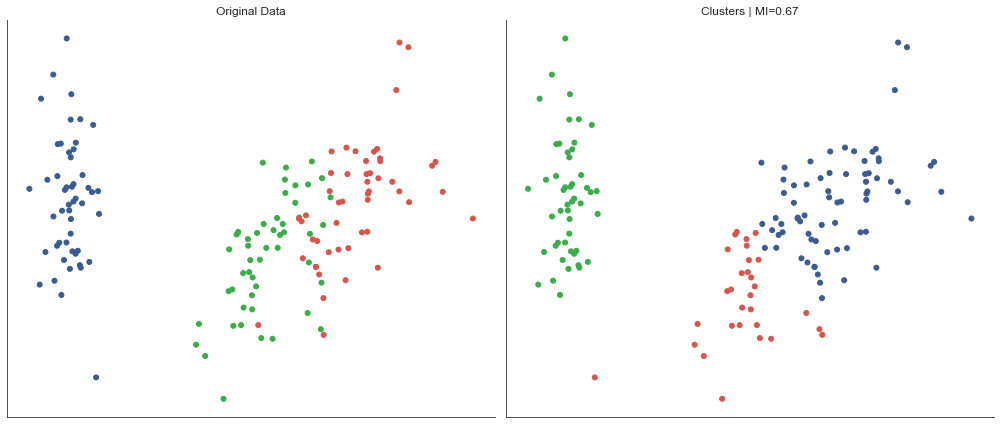

In [70]:
# Scikit-Learn implementation
clusterer = AgglomerativeClustering(n_clusters=3)
data['clusters'] = clusterer.fit_predict(features_standardized)
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)

axes[0].scatter(*features_2D.T,  c=data.label, s=25, cmap=cmap)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters, s=25, cmap=cmap)
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))
for i in [0, 1]:
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)

sns.despine()
fig.tight_layout()

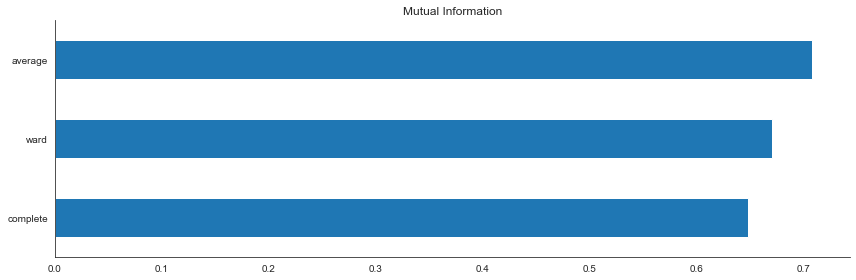

In [71]:
# Comparing Mutual Information for different Linkage Options
mutual_info = {}
for linkage_method in ['ward', 'complete', 'average']:
    clusterer = AgglomerativeClustering(n_clusters=3, linkage=linkage_method)
    clusters = clusterer.fit_predict(features_standardized)
    mutual_info[linkage_method] = adjusted_mutual_info_score(clusters, labels)
ax = (pd.Series(mutual_info).sort_values().plot.barh(figsize=(12, 4), title='Mutual Information'))
sns.despine()
plt.tight_layout()